# Year End Analysis Notebook

## This project is broken into 3 different sections. 

Section 1: Obsidian Journal Processing
Section 2: Timular Data Extraction via API
Section 3: Data visualizations

Reminder for Timeular is that you must have the ability to export data. As of Jan. 2024 that ability begins at the Personal Pro level.

---

## Section 0 - Import and variable information

In [1]:
# Imports for Obsidian
import frontmatter as pyfront
from yaml.scanner import ScannerError

# Imports for Timular
import requests
import json
from dotenv import load_dotenv
import pandas as pd
from io import StringIO

# Imports for all
import os
from pprint import pprint

# Imports for Jupyter
import plotly.graph_objects as pgo
import matplotlib.pyplot as plt



if os.path.exists(".env"):
    print(".env file already exist, which means API information should already be there. Skipping questions to gather that information")
else:
    print("The next questions are saved to a .env file that the project ignores.")
    vault = input(r"What is the absolute path for your daily note directory in your Obsidian Vault? ")
    timeular_api_key = input(r"What is your timeular Api Key? This will get saved to the .env file:  ")
    timeular_api_secret = input(r"What is your timeular Api Secret? This will get saved to the .env file:  ")
    with open(".env", "w") as env_file:
        env_file.write(f'TIMEULAR_API_KEY={timeular_api_key}')
        env_file.write(f'TIMEULAR_API_SECRET={timeular_api_secret}')
        env_file.write(f'VAULT_PATH={vault}')

 



.env file already exist, which means API information should already be there. Skipping questions to gather that information


---

## Section 1 - Obsidian Journal Frontmatter (Properties) Collection

In [2]:
# Frontmatter Documentation https://pypi.org/project/python-frontmatter/
# Primary collection module is pyfront

vault_path = os.getenv("VAULT_PATH")

def create_nested_dictionary_from_vault(directory):
    daily_dic = {}

    
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)


        if os.path.isfile(file_path):
            # Remove the file extension to get the key
            date_key = os.path.splitext(filename)[0]
            

            try:
                with open(file_path, 'r', encoding='utf-8') as file:
                    post = pyfront.loads(file.read())
                    daily_dic[date_key] = post.metadata
            except (UnicodeDecodeError, ScannerError) as e:
                print(f"Error in file {filename}: {e}")
                continue  # Skips the file causing the error
                # For complete data, go to the skipped files and fix the errors


    return daily_dic

result_nested_dictionary = create_nested_dictionary_from_vault(vault_path)

pprint(result_nested_dictionary["2023-12-01"]) # Test print of the nested dictionary to make sure it 

{'Code': None,
 'Enjoyment': None,
 'Home-Improvement': None,
 'Homelab': None,
 'Location': 'Phoenix',
 'Meditation': None,
 'MimirCyber': None,
 'Percentage': 27.5,
 'Post-workout-percent': None,
 'Post-workout-weight': None,
 'Reading': None,
 'Weight': 234,
 'Why': None,
 'Workout': 1,
 'aliases': None,
 'creation date': '2023-12-01 19:50',
 'date': None,
 'modification date': 'Friday 1st December 2023 19:50:14',
 'tags': ['daily-reviews']}


---

## Section 3a - Data Visualization Obsidian

## Weight and Percentage

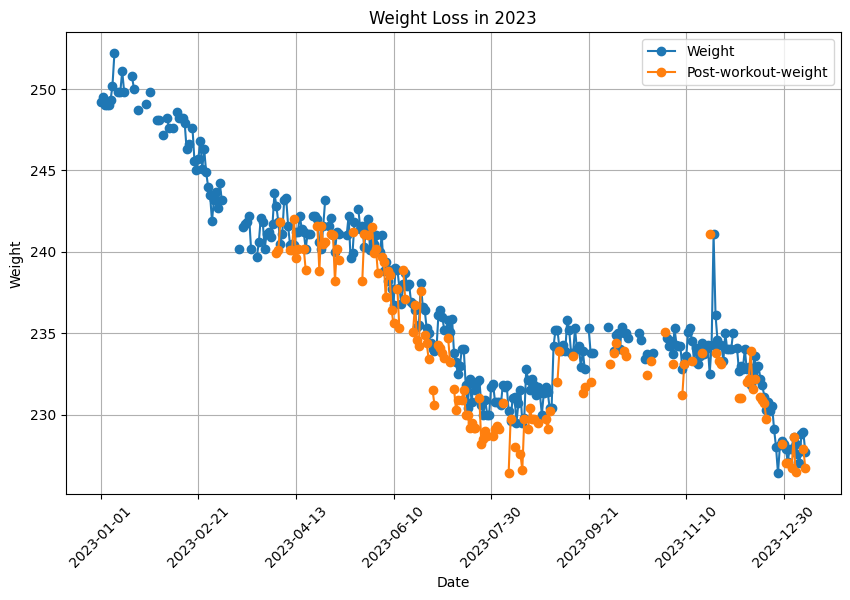

I was my heaviest at 252.2 lbs.
I was my lightest at 226.4 lbs.
That is a loss of 26 lbs. for the year


In [3]:
df = pd.DataFrame(result_nested_dictionary).T

plt.figure(figsize=(10,6))

df["Weight"].plot(kind="line", marker="o", linestyle="-")
df["Post-workout-weight"].plot(kind="line", marker="o", linestyle="-")

plt.title("Weight Loss in 2023")
plt.xlabel("Date")
plt.ylabel("Weight")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

print(f"I was my heaviest at {df['Weight'].max()} lbs.")
print(f"I was my lightest at {df['Weight'].min()} lbs.")
print(f"That is a loss of {round(df['Weight'].max()) - round(df['Weight'].min())} lbs. for the year")


## Activities

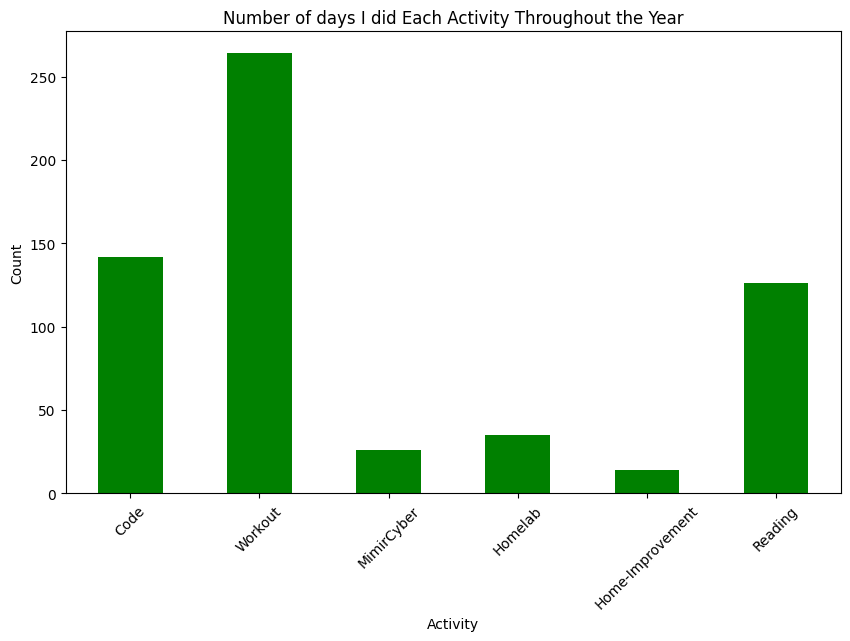

In [4]:
activities_columns = ['Code', 'Workout', 'MimirCyber', 'Homelab', 'Home-Improvement', 'Reading']
df_activities = df[activities_columns]

activities_count = df_activities.count()

plt.figure(figsize=(10,6))
activities_count.plot(kind="bar", color='green')
plt.title('Number of days I did Each Activity Throughout the Year')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

---

## Section 2 - Timular Data Extraction via API

In [5]:
#### Timeular API Documentation https://developers.timeular.com/#832677a3-73d5-4bde-85dc-40af433414c1 ####

# Secrets will load from ".env"
load_dotenv()
time_api = os.getenv("TIMEULAR_API_KEY")
time_secret = os.getenv("TIMEULAR_API_SECRET")
time_token = os.getenv("TIMEULAR_API_TOKEN")


# Timeular requires you to have an ApiKey and ApiSecret to get your ApiToken. This uses ApiKey and ApiSecret to make the required API Call.
token_payload = json.dumps({
    "apiKey": time_api,
    "apiSecret": time_secret,
})
token_headers = {
    'Content-Type': 'application/json'
}
token_url = "https://api.timeular.com/api/v3/developer/sign-in"
timeular_response_token = requests.request("POST", token_url, headers=token_headers, data=token_payload)
timeular_response_token.raise_for_status()
os.getenv('TIMEULAR_API_TOKEN', timeular_response_token.text)


# With your ApiToken, you can now export data for the dates in question. 
activities_headers = {
  'Authorization': f'Bearer {time_token}'
}
activities_payload = {}
activites_list_url = "https://api.timeular.com/api/v3/report/2023-01-01T00:00:00.000/2023-12-31T23:59:59.999?timezone=America/Chicago"
timeular_response_activites = requests.request("GET", activites_list_url, headers=activities_headers, data=activities_payload)
timeular_response_activites.raise_for_status()


acitivities_text = timeular_response_activites.text

# Setting output to be same directory as jupyter file
script_dir = os.getcwd()
output_file_path = os.path.join(script_dir, 'timeular_data.csv')

# Making the CSV readable for Jupyter manipulation
df = pd.read_csv(StringIO(acitivities_text))
df = df[['Space', 'StartDate', 'Activity', 'Duration', 'Tags']]
df.to_csv(output_file_path, index=False)

# Section 3b - Timular Visualization

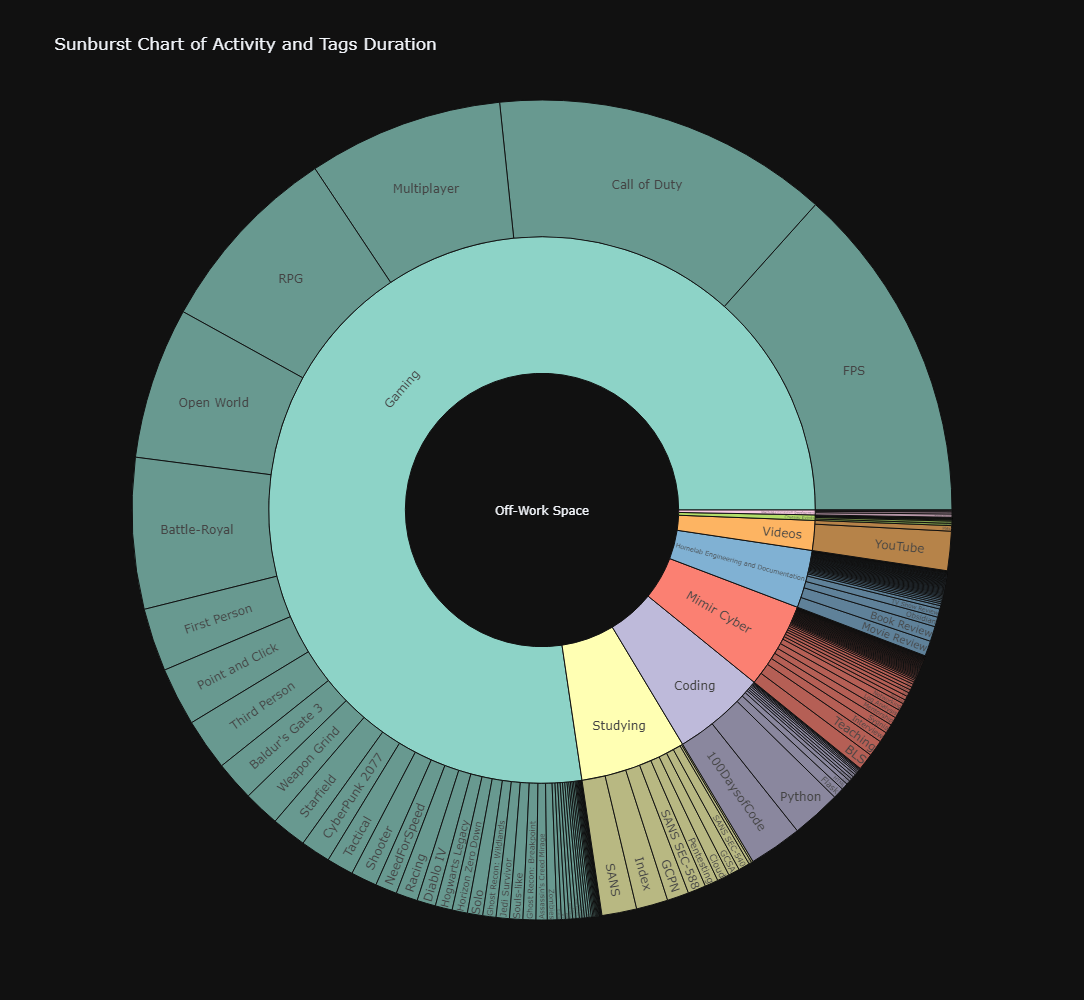

In [83]:
import plotly.express as px
import numpy as np

# Read the data from the CSV file
df = pd.read_csv('timeular_data.csv')

df['Duration'] = pd.to_timedelta(df['Duration'])
df['Duration_minutes'] = df['Duration'].dt.total_seconds() / 60


df_off_work = df[df['Space'] == 'Off-Work Space']

sunburst_df = pd.DataFrame(columns=['Space', 'Activity', 'Tags', 'Duration_minutes'])
for _, row in df_off_work.iterrows():
    tags = row['Tags'].split('#') if pd.notnull(row['Tags']) else ['']
    for tag in tags:
        sunburst_df = pd.concat([sunburst_df, pd.DataFrame({
            'Space': [row['Space']],
            'Activity': [row['Activity']],
            'Tags': [tag.strip()],
            'Duration_minutes': [row['Duration_minutes']]
        })], ignore_index=True)


sunburst_df.loc[sunburst_df['Tags'] == 'Other', 'Tags'] = 'Other_' + sunburst_df['Space']
sunburst_df = sunburst_df[sunburst_df['Tags'] != '']

fig = px.sunburst(sunburst_df, path=['Space', 'Activity', 'Tags'],
                  values='Duration_minutes',
                  title='Sunburst Chart of Activity and Tags Duration',
                  template='plotly_dark',
                  color_discrete_sequence=px.colors.qualitative.Set3)


fig.update_layout(width=2560, height=1440)
fig.write_html('sunburst_chart.html')


fig.update_layout(width=800, height=1000)
fig.show()